### Requirements:

- Công ty SuperStore là một công ty bán lẻ trên toàn cầu - Global. Nên công ty có rất nhiều khách hàng. Nhân dịp giáng sinh và năm mới, phòng Marketing muốn chạy các chiến dịch marketing để tri ân khách hàng đã ủng hộ công ty suốt thời gian qua. Cũng như khai thác các khách có tiềm năng trở thành khách hàng trung thành. 

- Tuy nhiên phòng Marketing vẫn chưa phân nhóm cho từng khách hàng của năm nay được vì tập dữ liệu quá lớn nên không thể xử lý bằng tay như các năm trước, nên nhờ Phòng Phân tích dữ liệu hỗ trợ triển khai một bài toán phân loại phân khúc của từng khách hàng để triển khai từng chương trình marketing phù hợp với từng nhóm khách hàng. 

- Giám đốc Marketing cũng có đề xuất phương án sử dụng mô hình RFM, tuy nhiên trước đây khi quy mô công ty nhỏ, team có thể tự tính và phân loại bằng excel. Hiện tại lượng data quá lớn nên mong muốn Phòng dữ liệu xây dựng luồng triển khai đánh giá Segmentation thông qua lập trình Python. 

In [4]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

#import data
xls = pd.ExcelFile('Dataset.xlsx')
orders =  pd.read_excel(xls, 'Orders')
product = pd.read_excel(xls, 'Product')
location = pd.read_excel(xls, 'Location')
customer = pd.read_excel(xls, 'Customer')
return1 = pd.read_excel(xls, 'Return')
segmentation = pd.read_excel(xls, 'Segmentation')

#exclude returned orders
orders_with_return = orders.merge(return1, how='left', on = 'Order ID' )
orders_with_return1 = orders_with_return.fillna('No')
orders_no_return = orders_with_return1[orders_with_return1['Returned'] == 'No']

#group by orders
groupby_orders = orders_no_return.groupby(['Order ID', 'Order Date', 'Customer ID'])['Sales'].sum()
groupby_orders = groupby_orders.reset_index()

#calculate RFM
today = datetime.datetime.strptime('2017-12-31', '%Y-%m-%d')
RFM = groupby_orders.groupby('Customer ID').agg({'Order Date':'max', 'Order ID':'count', 'Sales':'sum'}).reset_index()
RFM.columns = ['Customer ID', 'Order Date', 'Frequency', 'Monetary']
RFM['Recency'] = (today - RFM['Order Date'])
RFM = RFM.drop('Order Date', axis = 1)
RFM = RFM[['Customer ID', 'Recency', 'Frequency', 'Monetary']]

#convert Timedelta to Int
RFM.info()
RFM['Recency'] = RFM['Recency'].dt.days

#calculate RFM scores
RFM['R_score'] = pd.qcut(RFM['Recency'], 5, labels = [5,4,3,2,1])
RFM['F_score'] = pd.qcut(RFM['Frequency'], 5, labels = [1,2,3,4,5])
RFM['M_score'] = pd.qcut(RFM['Monetary'], 5, labels = [1,2,3,4,5])
RFM['RFM_score'] = RFM['R_score'].astype(str) + RFM['F_score'].astype(str) + RFM['M_score'].astype(str)
RFM['RFM_score'] = RFM['RFM_score'].astype(int)
RFM.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   Customer ID  791 non-null    object         
 1   Recency      791 non-null    timedelta64[ns]
 2   Frequency    791 non-null    int64          
 3   Monetary     791 non-null    float64        
dtypes: float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 24.8+ KB


,Customer ID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0,AA-10315,185,5,5563.560,2,2,5,225
1,AA-10375,20,9,1056.390,5,5,2,552
2,AA-10480,260,4,1790.512,2,1,3,213
3,AA-10645,483,5,5073.975,1,2,5,125
4,AB-10015,416,3,886.156,1,1,2,112


In [5]:
#convert comma-seperated values to list and unnest
segmentation['RFM Score'] = segmentation['RFM Score'].str.split(',')
segmentation = segmentation.explode('RFM Score')
segmentation['RFM Score'] = segmentation['RFM Score'].astype(int)
segmentation.head()

,Segment,RFM Score
0,Champions,555
0,Champions,554
0,Champions,544
0,Champions,545
0,Champions,454


In [6]:
#Join segmentation with RFM
customer_segmentation = RFM.merge(segmentation, left_on = 'RFM_score', right_on = 'RFM Score', how='left')
customer_segmentation = customer_segmentation.drop('RFM Score', axis=1)
customer_segmentation.head()

,Customer ID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
0,AA-10315,185,5,5563.560,2,2,5,225,At Risk
1,AA-10375,20,9,1056.390,5,5,2,552,Potential Loyalist
2,AA-10480,260,4,1790.512,2,1,3,213,About To Sleep
3,AA-10645,483,5,5073.975,1,2,5,125,At Risk
4,AB-10015,416,3,886.156,1,1,2,112,Lost customers


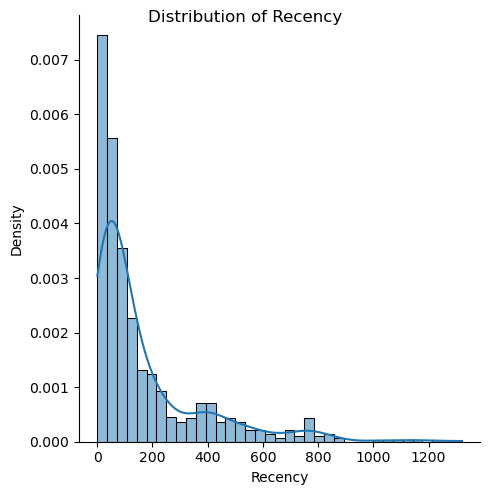

In [7]:
#Distribution of R,F,M
R_dist = sns.displot(customer_segmentation, x='Recency', kde=True, stat='density')
R_dist.fig.suptitle('Distribution of Recency')
plt.show()

- Recency phân bố chủ yếu ở 0-200, có nghĩa là khoảng giao dịch diễn ra gần nhất là trong khoảng 200 ngày, sau đó giảm dần trở đi. Có thể suy đoán rằng, trong vòng 200 ngày, lượng khách hàng cũ quay lại mua hàng khá nhiều, đi kèm đó có thể là khách hàng mới, sau 200 ngày thì lượng khách hàng quay lại mua hàng giảm nhiều, thời gian càng lâu thì lượng khách quay lại mua hàng càng ít => Đưa ra được phân khúc khách hàng

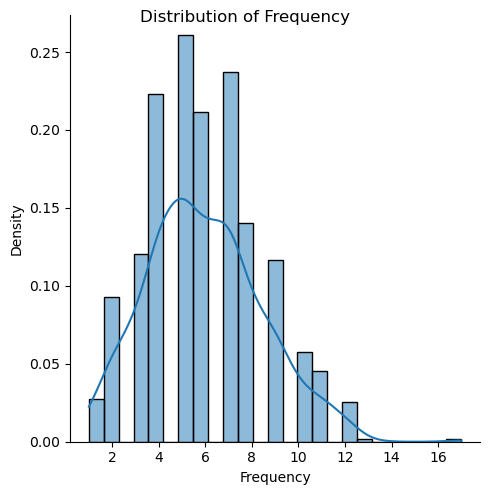

In [9]:
R_dist = sns.displot(customer_segmentation, x='Frequency', kde=True , stat='density')
R_dist.fig.suptitle('Distribution of Frequency')
plt.show()

- Frequency trải rộng từ 2 đến 10, nhiều nhất là ở 6 đơn hàng và sau đó giảm dần đến 12. Dựa vào đây có thể đưa ra giả thuyết rằng, từ số đơn hàng có thể suy đoán được khả năng tương tác của khách hàng với doanh nghiệp qua các chiến dịch quảng bá, PR,... Khi khách mua hàng liên tục, có nghĩa là chiến dịch quảng bá đó đang có hiệu quả tốt, tăng cường mối quan hệ của doanh nghiệp với khách hàng, đồng thời đánh giá được phân khúc khách hàng, những khách hàng có số đơn hàng nằm trong những khoảng 4-8 thường là những khách hàng trung thành, thân thiết. Từ đó đưa ra được chính sách ưu đãi khách hàng hợp lý, tăng tương tác qua lại của khách hàng và doanh nghiệp => Tăng doanh thu

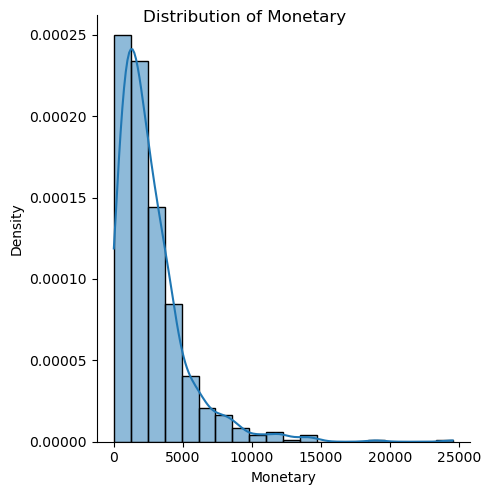

In [59]:
R_dist = sns.displot(customer_segmentation, x='Monetary', kde=True , stat='density', bins=20)
R_dist.fig.suptitle('Distribution of Monetary')
plt.show()

- Monetary nằm trong khoảng chủ yếu là 0-5000, với đỉnh cao nhất là ở 1000, từ đây có thể nhận ra được khả năng chi trả của khách hàng. Những mặt hàng nằm trong khoảng 0-5000 là những mặt hàng được ưa chuộng nhiều, có thể chạy những chiến dịch giảm giá, ưu đãi đưa giá cả hàng hóa về trong khoảng này để tăng khả năng bán hàng tồn kho, mặt hàng không bán chạy. Từ đó, khi đã được trải nghiệm chất lượng sản phẩm của những mặt hàng được giảm giá, khách hàng có đủ độ tin cậy để bỏ tiền ra mua khi những mặt hàng này không còn được giảm giá nữa. => Tăng doanh thu từ các loại hàng hóa khác của công ty

In [11]:
#Average R,F,M by customer segment
avg_groupby_segment = customer_segmentation.groupby('Segment').agg({'Customer ID':'count',
                                                                'Recency':'mean',
                                                                'Frequency':'mean',
                                                                'Monetary':'mean'})
avg_groupby_segment = avg_groupby_segment.reset_index()
avg_groupby_segment.columns=['Segment', 'Customers','Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
print(avg_groupby_segment)

                  Segment  Customers  Avg_Recency  Avg_Frequency  Avg_Monetary
0          About To Sleep         44   135.204545       4.750000   1075.229936
1                 At Risk         96   259.041667       7.260417   4020.800897
2        Cannot Lose Them         36   496.527778       4.694444   4173.053928
3               Champions         71    28.521127       9.830986   5381.642068
4   Hibernating customers         90   190.044444       4.733333   1221.780567
5          Lost customers         83   557.963855       2.975904    653.785849
6                   Loyal         62    60.725806       8.161290   4365.809926
7          Need Attention         72    50.138889       6.527778   3602.949892
8           New Customers         61    41.475410       3.393443    672.084279
9      Potential Loyalist        113    45.185841       7.079646   1689.778144
10              Promising         63    35.253968       4.507937   3568.315802


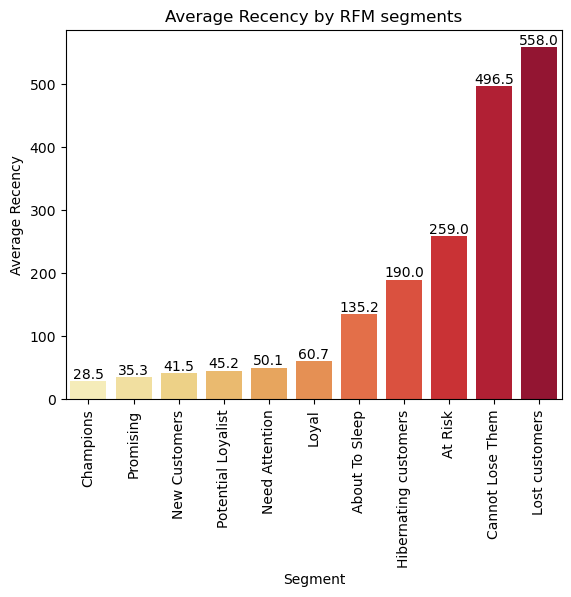

In [12]:
#Average Recency by RFM segment in bar plot
R_bar = sns.barplot(x='Segment',
                    y='Avg_Recency',
                    data=avg_groupby_segment.sort_values('Avg_Recency', ascending=True),
                    palette='YlOrRd')
R_bar.set_title('Average Recency by RFM segments')
R_bar.set(xlabel='Segment',
          ylabel='Average Recency')
R_bar.bar_label(R_bar.containers[0], fmt='%.1f')
plt.xticks(rotation=90)
plt.show()

- Phân khúc mua hàng gần nhất là Champions (28.5 ngày) và Promising (35.3 ngày)
- Phân khúc đã lâu không mua hàng là Cannot Lose Them (496.5 ngày) và Lost Customers (558.0 ngày)
- Phân khúc khách hàng từ Champions đến Loyal có sự khác biệt giữa thời gian mua hàng gần nhất ít, vì vậy đây là những phân khúc có thể tập trung vào, từ About to sleep trở đi sự cách biệt này ngày càng lớn.

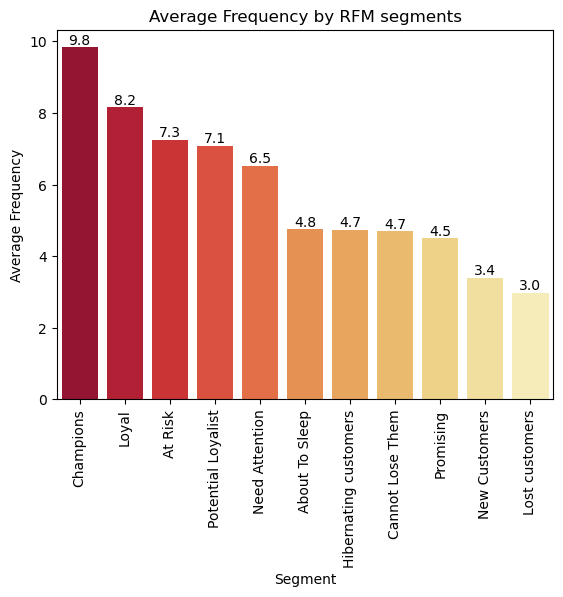

In [13]:
#Average Frequency by RFM segment in bar plot
R_bar = sns.barplot(x='Segment',
                    y='Avg_Frequency',
                    data=avg_groupby_segment.sort_values('Avg_Frequency', ascending=False),
                    palette='YlOrRd_r')
R_bar.set_title('Average Frequency by RFM segments')
R_bar.set(xlabel='Segment',
          ylabel='Average Frequency')
R_bar.bar_label(R_bar.containers[0], fmt='%.1f')
plt.xticks(rotation=90)
plt.show()

- Phân khúc mua hàng thường xuyên nhất là Champions (9.8 lần), Loyal (8.2 lần), At risk(7.3 lần)
- Phân khúc khách hàng ít mua hàng nhất là New Customers (3.4 lần), Lost Customers (3.0 lần)
- Sự khác biệt trong Frequency của cách phân khúc ngày càng giảm dần và cũng không quá nhiều như Recency (gần như giảm 1 lần mỗi bậc), nhóm khách hàng At risk lại có số lần mua hàng đứng top 3, điều này khá bất thường vì Recency của nhóm này ở top 3 phân khúc đã lâu không mua hàng => Có nghĩa là phân khúc At risk tập trung mua hàng vào một dịp đặc biệt như ngày lễ lớn (Valentine), dịp đặc biệt (Black Friday)

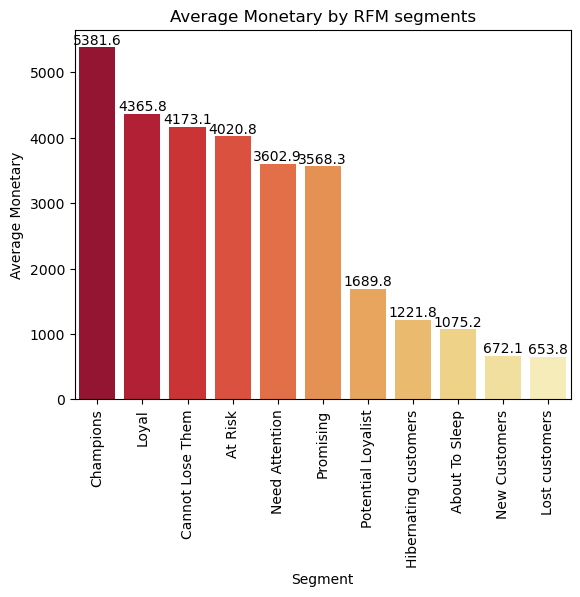

In [14]:
#Average Monetary by RFM segment in bar plot
R_bar = sns.barplot(x='Segment',
                    y='Avg_Monetary',
                    data=avg_groupby_segment.sort_values('Avg_Monetary', ascending=False),
                    palette='YlOrRd_r')
R_bar.set_title('Average Monetary by RFM segments')
R_bar.set(xlabel='Segment',
          ylabel='Average Monetary')
R_bar.bar_label(R_bar.containers[0], fmt='%.1f')
plt.xticks(rotation=90)
plt.show()

- Phân khúc bỏ ra số tiền trung bình nhiều nhất là Champions (5381.6 đô) và Loyal (4365.8 đô)
- Phân khúc bỏ ra số tiền trung bình ít nhất là New customers (672.1 đô) và Lost customers (653.8 đô)
- Những khách hàng trung thành và có quan hệ tốt với doanh nghiệp nhất là những người bỏ ra nhiều tiền nhất để mua sản phẩm vì đối với họ công ty đã có uy tín, với nhóm chưa sẵn sàng dùng tiền vào sản phẩm của doanh nghiệp vì có thể là chưa trải nghiệm sản phẩm nên chưa đủ độ tin cậy (New customers) và một vài nhóm khác có thể không có nhiều nhu cầu đối với các loại sản phẩm của doanh nghiệp. Tuy nhiên đây là phân tích số tiền trung bình được sử dụng để tìm ra xu hướng của phân khúc khách hàng nên có thể chưa thể hiện rõ hoàn toàn, phân khúc At risk được giả định là có xu hướng mua hàng vào những dịp đặc biệt nên thường họ có thể sẽ bỏ ra tổng số tiền nhiều nhất trong tất cả phân khúc

In [64]:
#Total number of customers and sales by segment
total_groupby_segment = customer_segmentation.groupby('Segment').agg({'Customer ID':'count',
                                                                'Monetary':'sum'})
total_groupby_segment = total_groupby_segment.reset_index()
total_groupby_segment.columns = ['Segment','Customers','Sales']
print(total_groupby_segment)

                  Segment  Customers        Sales
0          About To Sleep         44   47310.1172
1                 At Risk         96  385996.8861
2        Cannot Lose Them         36  150229.9414
3               Champions         71  382096.5868
4   Hibernating customers         90  109960.2510
5          Lost customers         83   54264.2255
6                   Loyal         62  270680.2154
7          Need Attention         72  259412.3922
8           New Customers         61   40997.1410
9      Potential Loyalist        113  190944.9303
10              Promising         63  224803.8955


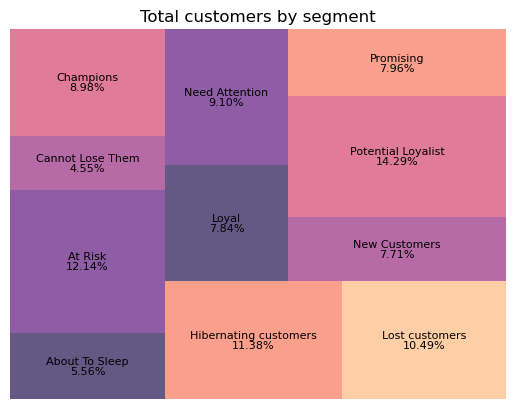

In [65]:
order = ['Champions',]
sum = total_groupby_segment['Customers'].sum()
squarify.plot(sizes = total_groupby_segment['Customers'],
              label = total_groupby_segment['Segment'],
              value = [f'{x*100/sum:.2f}%' for x  in total_groupby_segment['Customers']],
              color = sns.color_palette("magma"),
              alpha = 0.7,
              text_kwargs = {'fontsize': 8})
plt.title('Total customers by segment')
plt.axis('off')
plt.show()

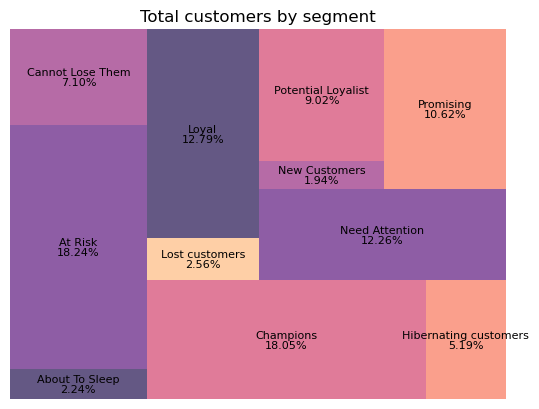

In [68]:
#Total number of customers by segment
sum = total_groupby_segment['Sales'].sum()
squarify.plot(sizes = total_groupby_segment['Sales'],
              label = total_groupby_segment['Segment'],
              value = [f'{x*100/sum:.2f}%' for x  in total_groupby_segment['Sales']],
              color = sns.color_palette("magma"),
              alpha = 0.7,
              text_kwargs = {'fontsize': 8})
plt.title('Total customers by segment')
plt.axis('off')
plt.show()

### Customer segmentation analysis:
1. Phân khúc Champions
- Chiếm 8.98% tổng số lượng khách hàng, 18.05% tổng doanh thu, có số lần mua hàng nhiều nhất, thời gian mua hàng gần nhất top 1 và số tiền trung bình bỏ ra cũng cao nhất. Đây là nhóm khách hàng quan trọng nhất của công ty => Công ty nên áp dụng dịch vụ chăm sóc khách hàng tốt nhất cho phân khúc này, đi kèm với những loại ưu đãi và phiếu quà tặng,... Thường xuyên chạy marketing các loại sản phẩm mới với phân khúc này để thu hút mua hàng nhiều hơn

2. Phân khúc Loyal và Potential Loyalist
- Loyal chiếm 7.84% tổng số lượng khách hàng, 12.79% tổng doanh thu, có số lần mua hàng xếp thứ 2, trung bình thời gian mua hàng gần nhất là 60 ngày và số tiền trung bình bỏ ra top 2.
- Potential loyalist chiếm 14.29% tổng số lượng khách hàng, 9.02% tổng doanh thu, trung bình thời gian mua hàng gần nhất là 45 ngày, số lần mua hàng khá cao (7.1 lần) và số tiền trung bình bỏ ra chỉ ở khoảng giữa của các phân khúc => 2 nhóm khách hàng này cũng là những nhóm khách hàng rất quan trọng, nhóm Loyal có tiềm năng phát triển thành Champions và nhóm Potential loyalist thì là Loyal. Nên áp dụng chăm sóc khách hàng tốt với 2 phân khúc này, để họ nhận ra mình là người đặc biệt dược doanh nghiệp chăm sóc, từ đó có gia tăng tương tác và độ tin cậy đối với doanh nghiệp. Khi độ tin cậy của khách hàng đủ lớn, bắt đầu đề xuất các mặt hàng giá trị hơn cũng như đưa ra chương trình ưu đãi, khuyến mãi cho họ

3. Phân khúc New customers và Promising
- New customers chiếm 7.71% tổng số lượng khách hàng, 1.94% tổng doanh thu, trung bình thời gian mua hàng gần nhất là 41.5 ngày, nhóm này có số lần mua hàng và số tiền trung bình bỏ ra thấp thứ 2
- Promising chiếm 7.96% tổng số lượng khách hàng, 10.62% tổng doanh thu, trung bình thời gian mua hàng gần nhất cao thứ 2 với 35.3 ngày, tuy nhiên nhóm này có số lần mua hàng khá thấp và số tiền trung bình bỏ ra chỉ ở mức trung bình => 2 phân khúc này là những phân khúc mới bắt đầu trải nghiệm sản phẩm của doanh nghiệp, độ tin cậy của họ đối với sản phẩm còn chưa cao nên cần phải có sự tư vấn tận tình của dịch vụ chăm sóc khách hàng, đồng thời duy trì mối quan hệ của thường xuyên hơn, đưa ra những ưu đãi kèm với kèm với những mô tả cần thiết của sản phẩm để khách hàng cởi mở hơn. Khuyến khích mua hàng bằng cách chạy chương trình càng mua càng ưu đãi, nhờ họ viết trải nghiệm và cảm nhận của bản thân về sản phẩm để thu hút những người mới hơn.

4. Phân khúc Need Attention và About to sleep
- Need attention chiếm 9.1% tổng số lượng khách hàng, 12.26% tổng doanh thu, trung bình thời gian mua hàng gần nhất là 50.1 ngày, số lần mua hàng và số tiền trung bình bỏ ra ở mức tương đối
- About to sleep chiếm 5.56% tổng số lượng khách hàng, 2.24% tổng doanh thu, trung bình thời gian mua hàng gần nhất là 135.2 ngày, số lần mua hàng ở mức trung bình và số tiền trung bình bỏ ra hơi thấp => 2 nhóm này không quay trở lại mua hàng gần đây, doanh nghiệp nên tìm rõ lý do, có thể vì chất lượng sản phẩm và dịch vụ hoặc là giá cả không hợp lý, ngoài ra nên chạy thêm chiến dịch như "Chào mừng quay trở lại" giảm giá mạnh tay các loại sản phẩm trước đó 2 nhóm này thường mua đồng thời khuyến khích trải nghiệm thêm các loại sản phẩm khác

5. Phân khúc At risk và Cannot lose them
- At risk chiếm 12.14% tổng số lượng khách hàng, 18.24% tổng doanh thu, trung bình thời gian mua hàng gần nhất là 259 ngày, số lần mua hàng ở top 3 với 7.3 lần và số tiền trung bình bỏ ra cũng ở top 4
- Cannot lose them chiếm 4.55% tổng số lượng khách hàng, 7.1% tổng doanh thu, trung bình thời gian mua hàng gần nhất là 495 ngày, số lần mua hàng tương đối thấp và số tiền trung bình bỏ ra ở top 3 => 2 phân khúc này có xu hướng mua hàng theo nhu cầu, với At risk họ sẵn sàng bỏ tiền (tổng doanh thu cao nhất) và mua nhiều lần nhưng lại có thời gian mua hàng gần nhất thấp nghĩa là họ chịu chi tiền vào một dịp nhất định trong năm. Tìm hiểu khoảng thời gian phân khúc At risk hay mua hàng, lợi dụng điều này để chạy chương trình, quảng cáo và vào những dịp đặc biệt trong năm áp dụng marketing, PR sản phẩm kèm ưu đãi để tăng Recency của nhóm này. Với cannot lose them, có cảm giác như phân khúc này khi nào cần sản phẩm gì thì mới mua, họ mua sản phẩm họ cần và  không quan tâm đến những sản phẩm khác. Tìm hiểu category và sub-category họ hay mua, từ đó gợi ý thêm những sản phẩm cùng loại, có thể thúc đẩy nhu cầu của khách hàng.

6. Phân khúc Hybernating và Lost customers 
- Hybernating chiếm 11.38% tổng số lượng khách hàng, 5.19% tổng doanh thu, trung bình thời gian mua hàng gần nhất là 190 ngày, số lần mua hàng và số tiền trung bình bỏ ra ở mức tương đối
- Lost customers chiếm 10.49% tổng số lượng khách hàng, 2.56% tổng doanh thu, trung bình thời gian mua hàng gần nhất là thấp nhất (558 ngày), số lần mua hàng và số tiền trung bình bỏ ra cũng ở đứng cuối => 2 phân khúc này dường như doanh nghiệp đã bị mất liên lạc, số lần mua hàng và đóng góp doanh thu ít, tuy nhiên lượng khách hàng của 2 phân khúc khá nhiều nên khi kết nối lại được với họ thì có thể là một nguồn tài nguyên mới. Tăng tương tác với 2 nhóm này qua social media, gửi email, chạy chương trình "Tri ân khách hàng lâu năm", tạo nhu cầu cho khách hàng.

- Trong các chỉ số R,F,M đối với team marketing thì chỉ số R là quan trọng nhất. Recency thể hiện độ tương tác giữa khách hàng và doanh nghiệp, nếu Recency cao nghĩa là khách hàng quay lại sử dụng sản phẩm của doanh nghiệp nhiều -> Chiến dịch marketing, PR có hiệu quả và chất lượng sản phẩm có được uy tín. Mục đích của việc chạy marketing là để tăng doanh thu và độ nhận biết của sản phẩm cũng như sự hiện diện của doanh nghiệp đối với khách hàng, vì vậy khi R cao có thể dẫn đến F, M cũng tăng cao tùy thuộc vào giá trị sản phẩm.
- Đối với team sales, chỉ số quan trọng nhất là F. Frequency thể hiện độ hài lòng của khách hàng với sản phẩm của doanh nghiệp, sản phẩm tốt thì mua thường xuyên và mua nhiều. Những phân khúc có Frequency cao đều có Monetary cao, tăng được độ hài lòng của khách hàng về sản phẩm -> Khách hàng mua nhiều -> Tăng doanh thu.